In [6]:
import pandas as pd
import numpy as np
import re
import random as rd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as missing
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler


In [67]:
df = pd.read_excel(r'not_cleaned_data.xlsx')
df.head()

,Row ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


# preprocessing

In [68]:
df.set_index('Row ID' , inplace=True)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10287 entries, 1 to 7177
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order Date     10287 non-null  datetime64[ns]
 1   Ship Date      10287 non-null  datetime64[ns]
 2   Ship Mode      10271 non-null  object        
 3   Customer ID    10287 non-null  object        
 4   Customer Name  10283 non-null  object        
 5   Segment        10287 non-null  object        
 6   Country        10287 non-null  object        
 7   City           10287 non-null  object        
 8   State          10283 non-null  object        
 9   Postal Code    10287 non-null  int64         
 10  Region         10287 non-null  object        
 11  Product ID     10287 non-null  object        
 12  Category       10276 non-null  object        
 13  Sub-Category   10287 non-null  object        
 14  Product Name   10287 non-null  object        
 15  Sales          10287 non-

<Axes: >

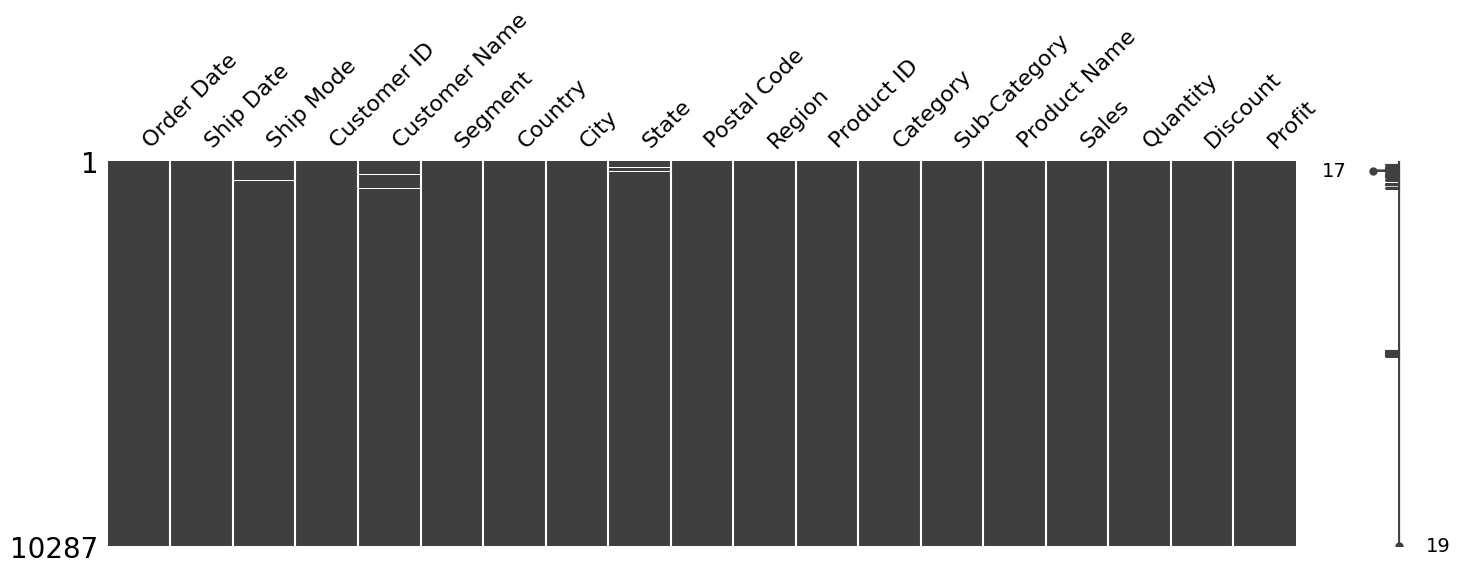

In [70]:
missing.matrix(df , figsize=(17,5))

# Cost

In [71]:
df['Cost'] = df['Sales'] - df['Profit']

# Order Date & Ship Date & Ship Mode

In [72]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

In [73]:
df['distribution'] =df['Ship Date']-df['Order Date']

In [74]:
x = df['Ship Mode'].unique()
class_ = np.delete(x , 3)
class_

array(['Second Class', 'Standard Class', 'First Class', 'Same Day'],
      dtype=object)

In [75]:
df.pivot_table(index= 'Ship Mode'  , values='distribution', aggfunc=['min','max' , 'mean'])



,min,max,mean
,distribution,distribution,distribution
Ship Mode,,,
First Class,1 days,4 days,2 days 04:16:46.799230275
Same Day,0 days,1 days,0 days 01:01:29.679715302
Second Class,1 days,5 days,3 days 05:31:19.267689262
Standard Class,3 days,7 days,5 days 00:10:06.167400881


In [76]:
nan_Mode = df['Ship Mode'].isna()

In [77]:
df.loc[(nan_Mode) & (df['distribution'] >= pd.Timedelta('2 days')) & (df['distribution'] <= pd.Timedelta('4 days')) , 'Ship Mode'] = 'Second Class'
df.loc[(nan_Mode) & (df['distribution'] >= pd.Timedelta('5 days')) , 'Ship Mode'] = 'Standard Class'
df['Ship Mode'].isna().sum()

np.int64(0)

# Customer Name

In [78]:
df.loc[df['Customer Name'].isna()]

,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Cost,distribution
Row ID,,,,,,,,,,,,,,,,,,,,,
261,2017-12-01,2017-12-03,Second Class,CC-12670,NaN,Consumer,United States,New York City,NaN,10009,...,OFF-BI-10003460,Office Supplies,Binders,Acco 3-Hole Punch,17.520,5,0.2,6.1320,11.3880,2 days
361,2017-03-08,2017-03-11,First Class,VB-21745,NaN,Corporate,United States,Columbus,Georgia,31907,...,OFF-LA-10001158,Office Supplies,Labels,"Avery Address/Shipping Labels for Typewriters,...",20.700,2,0.0,9.9360,10.7640,3 days
621,2017-08-18,2017-08-23,Second Class,NG-18355,NaN,Corporate,United States,New York City,New York,10011,...,FUR-FU-10000521,Furniture,Furnishings,"Seth Thomas 14"" Putty-Colored Wall Clock",88.020,3,0.0,27.2862,60.7338,5 days
735,2017-01-21,2017-01-25,Standard Class,DS-13030,NaN,Home Office,United States,Seattle,Washington,98115,...,OFF-BI-10003982,Office Supplies,Binders,Wilson Jones Century Plastic Molded Ring Binders,99.696,6,0.2,33.6474,66.0486,4 days


In [79]:
nan_ID = df[df['Customer Name'].isna()]['Customer ID']
nan_ID

Row ID
261    CC-12670
361    VB-21745
621    NG-18355
735    DS-13030
Name: Customer ID, dtype: object

In [80]:
for i in nan_ID:
    df.loc[df['Customer ID'].isin([i]) , 'Customer Name'] = df.loc[df['Customer ID'].isin([i]) , 'Customer Name'].ffill()

# State

In [81]:
df.loc[df['State'].isna()]

,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Cost,distribution
Row ID,,,,,,,,,,,,,,,,,,,,,
173,2014-08-05,2014-08-09,Standard Class,CS-12130,Chad Sievert,Consumer,United States,Los Angeles,NaN,90004,...,OFF-PA-10001144,Office Supplies,Paper,Xerox 1913,110.960,2,0.0,53.2608,57.6992,4 days
174,2014-08-05,2014-08-09,Standard Class,CS-12130,Chad Sievert,Consumer,United States,Los Angeles,NaN,90004,...,FUR-CH-10003817,Furniture,Chairs,"Global Value Steno Chair, Gray",340.144,7,0.2,21.2590,318.8850,4 days
261,2017-12-01,2017-12-03,Second Class,CC-12670,Craig Carreira,Consumer,United States,New York City,NaN,10009,...,OFF-BI-10003460,Office Supplies,Binders,Acco 3-Hole Punch,17.520,5,0.2,6.1320,11.3880,2 days
281,2015-09-26,2015-09-28,Second Class,SC-20725,Steven Cartwright,Consumer,United States,Houston,NaN,77070,...,OFF-BI-10004967,Office Supplies,Binders,Round Ring Binders,2.080,5,0.8,-3.4320,5.5120,2 days


In [82]:
nan_City = df.loc[df['State'].isna() , 'City']
nan_City

Row ID
173      Los Angeles
174      Los Angeles
261    New York City
281          Houston
Name: City, dtype: object

In [83]:
for i in nan_City:
    df.loc[df['City'].isin([i]) , 'State'] = df.loc[df['City'].isin([i]) , 'State'].ffill()


# Category

In [84]:
df['Segment'].value_counts()

Segment
Consumer       5360
Corporate      3112
Home Office    1815
Name: count, dtype: int64

In [85]:
nan_sub_category = df.loc[df['Category'].isna() , 'Sub-Category']
nan_sub_category

Row ID
226             Art
263        Machines
296     Furnishings
371           Paper
434         Storage
5077        Storage
5107    Accessories
5135        Binders
5166          Paper
5193    Furnishings
5226        Binders
Name: Sub-Category, dtype: object

In [86]:
df[df['Sub-Category'] == 'Art']['Category'].isna().sum()

np.int64(1)

In [87]:
for i in nan_sub_category:
    df.loc[df['Sub-Category'].isin([i]) , 'Category'] = df.loc[df['Sub-Category'].isin([i]) , 'Category'].ffill()

# Handling Data types

In [88]:
def preprocessing(df):
    for i in df.columns:
        if df[i].dtype == 'object':
            df[i] = df[i].astype('string')
            print(i)

In [89]:
preprocessing(df)

Ship Mode
Customer ID
Customer Name
Segment
Country
City
State
Region
Product ID
Category
Sub-Category
Product Name


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10287 entries, 1 to 7177
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   Order Date     10287 non-null  datetime64[ns] 
 1   Ship Date      10287 non-null  datetime64[ns] 
 2   Ship Mode      10287 non-null  string         
 3   Customer ID    10287 non-null  string         
 4   Customer Name  10287 non-null  string         
 5   Segment        10287 non-null  string         
 6   Country        10287 non-null  string         
 7   City           10287 non-null  string         
 8   State          10287 non-null  string         
 9   Postal Code    10287 non-null  int64          
 10  Region         10287 non-null  string         
 11  Product ID     10287 non-null  string         
 12  Category       10287 non-null  string         
 13  Sub-Category   10287 non-null  string         
 14  Product Name   10287 non-null  string         
 15  Sales   

In [91]:
df.to_pickle("cleaned_data.pkl")

# EDA

# Relation 1

In [92]:
category_counts = df['Category'].value_counts()
category_counts.to_frame()


,count
Category,
Office Supplies,6219
Furniture,2172
Technology,1896


In [93]:
Category_sales = df.groupby('Category')['Sales'].sum()
Category_sales.to_frame()

,Sales
Category,
Furniture,759803.1573
Office Supplies,734819.3500
Technology,858733.1350


In [94]:
Category_cost= df.groupby('Category')['Cost'].sum()
Category_cost.to_frame()

,Cost
Category,
Furniture,740040.8248
Office Supplies,608746.2119
Technology,709073.8615


In [95]:
Category_profit = df.groupby('Category')['Profit'].sum()
Category_profit.to_frame()

,Profit
Category,
Furniture,19762.3325
Office Supplies,126073.1381
Technology,149659.2735


In [96]:
Category_computing = df.groupby('Category')[['Sales','Cost','Profit']].sum()
Category_computing

,Sales,Cost,Profit
Category,,,
Furniture,759803.1573,740040.8248,19762.3325
Office Supplies,734819.3500,608746.2119,126073.1381
Technology,858733.1350,709073.8615,149659.2735


# Relation 2

In [97]:
technology = df[df['Category']=='Technology']
Technology_Sub_Category = technology.groupby('Sub-Category')['Sales'].sum().sort_values(ascending=False)
Technology_Sub_Category

Sub-Category
Phones         342124.030
Machines       189718.619
Accessories    171482.582
Copiers        155407.904
Name: Sales, dtype: float64

In [98]:
Furniture = df[df['Category']=='Furniture']
Furniture_Sub_Category = Furniture.groupby(['Sub-Category'])['Sales'].sum().sort_values(ascending=False)
Furniture_Sub_Category

Sub-Category
Chairs         338247.8000
Tables         210961.2380
Bookcases      116781.8533
Furnishings     93812.2660
Name: Sales, dtype: float64

In [99]:
Office_Supplies	= df[df['Category']=='Office Supplies']
Office_Supplies_Sub_Category = Office_Supplies.groupby('Sub-Category')['Sales'].sum().sort_values(ascending=False)
Office_Supplies_Sub_Category


Sub-Category
Storage       228439.778
Binders       205528.783
Appliances    110851.463
Paper          81685.884
Supplies       47085.110
Art            28216.790
Envelopes      16886.306
Labels         13060.556
Fasteners       3064.680
Name: Sales, dtype: float64

In [100]:
Office_Supplies_Sub_Category_pie = Office_Supplies.groupby('Sub-Category')['Sales'].sum().sort_values(ascending=False).head(6)
Office_Supplies_Sub_Category_pie

Sub-Category
Storage       228439.778
Binders       205528.783
Appliances    110851.463
Paper          81685.884
Supplies       47085.110
Art            28216.790
Name: Sales, dtype: float64

In [101]:
explode_len = [.17 for i in Office_Supplies_Sub_Category_pie.index]
explode_len

[0.17, 0.17, 0.17, 0.17, 0.17, 0.17]

# Realation 3

In [102]:
Top_20_State_sales = df.groupby(['State'])['Sales'].sum().sort_values(ascending=False).head(20)

# Relation 4


In [103]:
profit = df.groupby(['Customer Name' , 'Segment' ,'Discount' ])[['Sales' , 'Cost' , 'Profit']].sum().sort_values(by = 'Sales' ,ascending=False).head(10)
profit

,,,Sales,Cost,Profit
Customer Name,Segment,Discount,,,
Sean Miller,Home Office,0.5,23459.780,25287.2844,-1827.5044
Tamara Chand,Corporate,0.0,18920.060,9932.8321,8987.2279
Raymond Buch,Consumer,0.0,14815.910,7895.3825,6920.5275
Hunter Lopez,Consumer,0.0,12857.650,7240.3064,5617.3436
Sanjit Chand,Consumer,0.0,12558.990,6822.6539,5736.3361
Adrian Barton,Consumer,0.0,11962.200,6286.9620,5675.2380
Tom Ashbrook,Home Office,0.2,11199.968,7279.9792,3919.9888
Ken Lonsdale,Consumer,0.0,11015.920,9954.7600,1061.1600
Sanjit Engle,Consumer,0.0,10140.800,6911.3630,3229.4370


# Relation 5

In [104]:
company_computing = df[['Sales', 'Cost' ,'Profit' ]].sum()
company_computing

Sales     2.353356e+06
Cost      2.057861e+06
Profit    2.954947e+05
dtype: float64

# Relation 6

In [105]:
Company_Productivity = df[['Profit' ,'Cost' , 'Sales']].agg(['min' , 'mean' , 'max'])
Company_Productivity

,Profit,Cost,Sales
min,-6599.978000,0.554400,0.444000
mean,28.725065,200.044804,228.769869
max,8399.976000,24449.558400,22638.480000


# Visualization

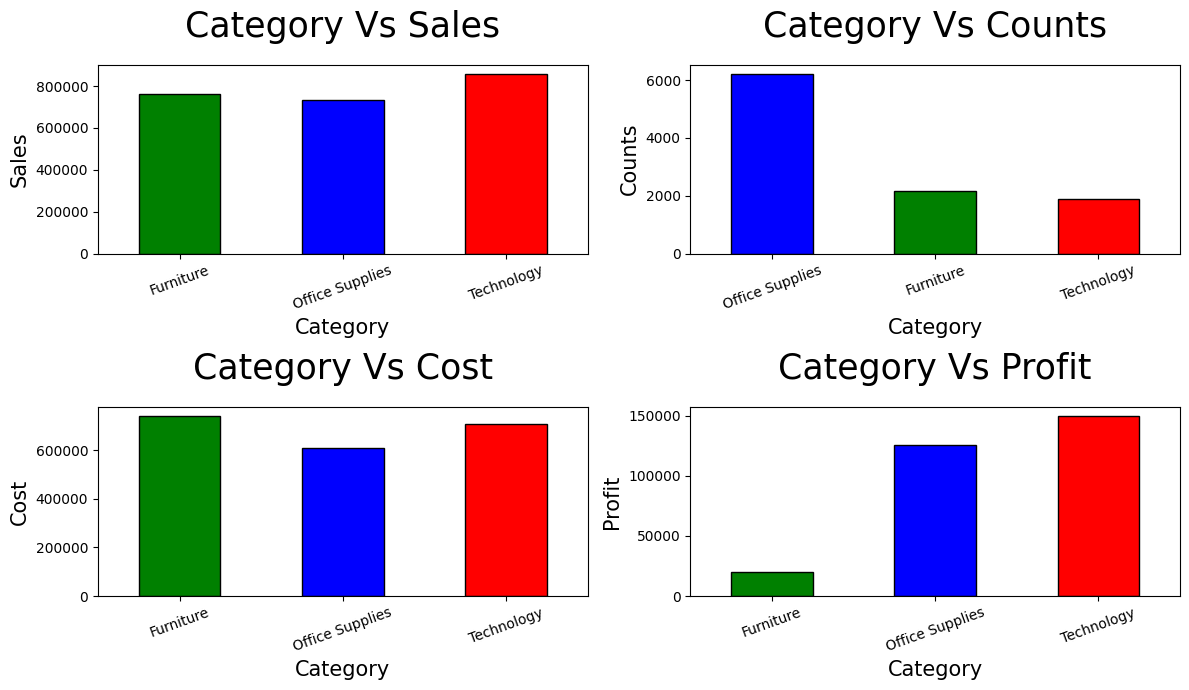

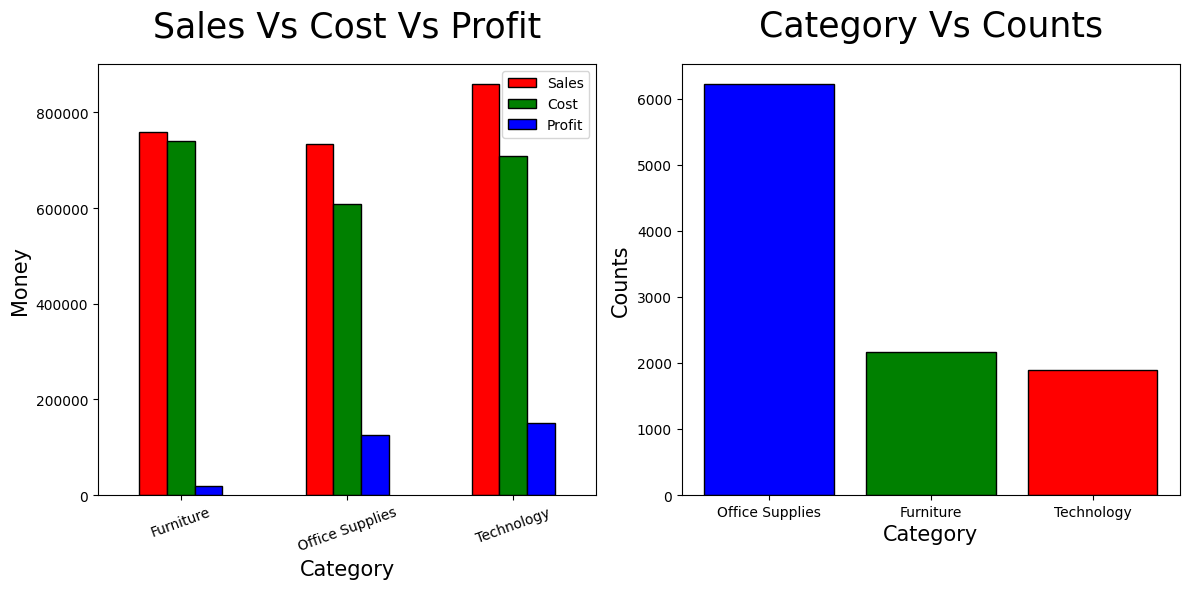

In [106]:
fig,ax = plt.subplots(2,2 , figsize=(12,7))
Category_sales.plot(
    kind='bar',
    edgecolor = 'black',
    color = ['g' , 'b' , 'r'],
    ax=ax[0][0]
)

category_counts.plot(
    kind='bar' , 
    edgecolor = 'black' , 
    color = ['b' , 'g' , 'r'] , 
    ax= ax[0][1]
)

Category_cost.plot(
    kind='bar' ,
    edgecolor = 'black' , 
    color = ['g' , 'b' , 'r'] ,
    ax = ax[1][0]
)

Category_profit.plot(
    kind='bar' ,
    edgecolor = 'black' , 
    color = ['g' , 'b' , 'r'] ,
    ax = ax[1][1]
)


ax[0][0].set_xlabel('Category' , fontsize = 15)
ax[0][0].set_ylabel('Sales' , fontsize = 15)
ax[0][0].set_title('Category Vs Sales' , fontsize = 25 , pad = 20)
ax[0][0].tick_params(axis = 'x', rotation=20)

ax[0][1].set_xlabel('Category' , fontsize = 15)
ax[0][1].set_ylabel('Counts' , fontsize = 15)
ax[0][1].set_title('Category Vs Counts' , fontsize = 25 ,pad = 20)
ax[0][1].tick_params(axis = 'x', rotation=20)

ax[1][0].set_xlabel('Category' , fontsize = 15)
ax[1][0].set_ylabel('Cost' , fontsize = 15)
ax[1][0].set_title('Category Vs Cost' , fontsize = 25 , pad = 20)
ax[1][0].tick_params(axis = 'x', rotation=20)

ax[1][1].set_xlabel('Category' , fontsize = 15)
ax[1][1].set_ylabel('Profit' , fontsize = 15)
ax[1][1].set_title('Category Vs Profit' , fontsize = 25  , pad = 20)
ax[1][1].tick_params(axis = 'x', rotation=20)


plt.tight_layout()
plt.show()


fig,ax = plt.subplots(1,2 , figsize=(12,6))
Category_computing[['Sales','Cost','Profit']].plot(kind='bar' , ax=ax[0],
    edgecolor = 'black',
    color = ['r' , 'g' , 'b']
)

ax[1].bar(
    x = category_counts.index ,
    height = category_counts.values ,
    edgecolor = 'black' , 
    color = ['b' , 'g' , 'r']
)


ax[0].set_xlabel('Category' , fontsize = 15)
ax[0].set_ylabel('Money' , fontsize = 15)
ax[0].set_title('Sales Vs Cost Vs Profit' , fontsize = 25 , pad = 20)
ax[0].tick_params(axis = 'x', rotation=20)

ax[1].set_xlabel('Category' , fontsize = 15)
ax[1].set_ylabel('Counts' , fontsize = 15)
ax[1].set_title('Category Vs Counts' , fontsize = 25 , pad = 20)


plt.tight_layout()
plt.show()

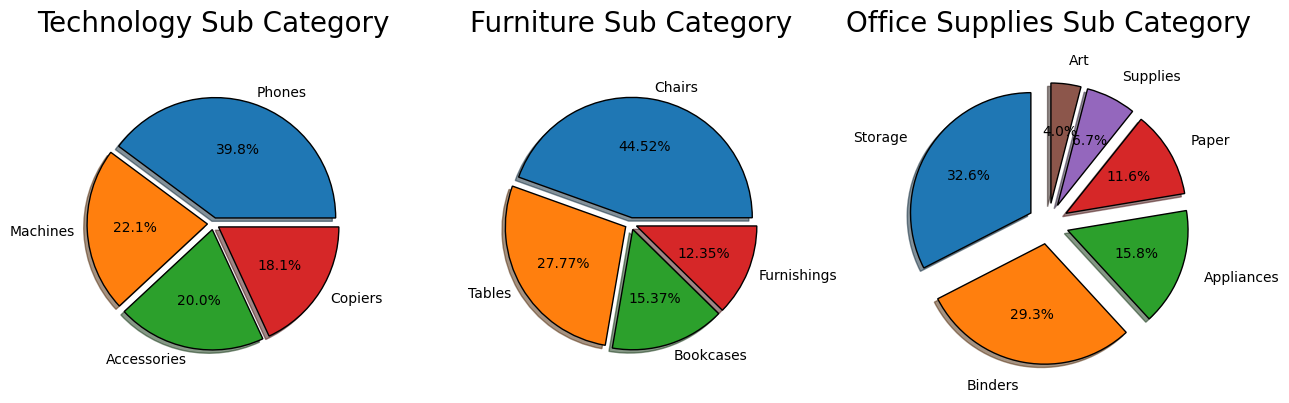

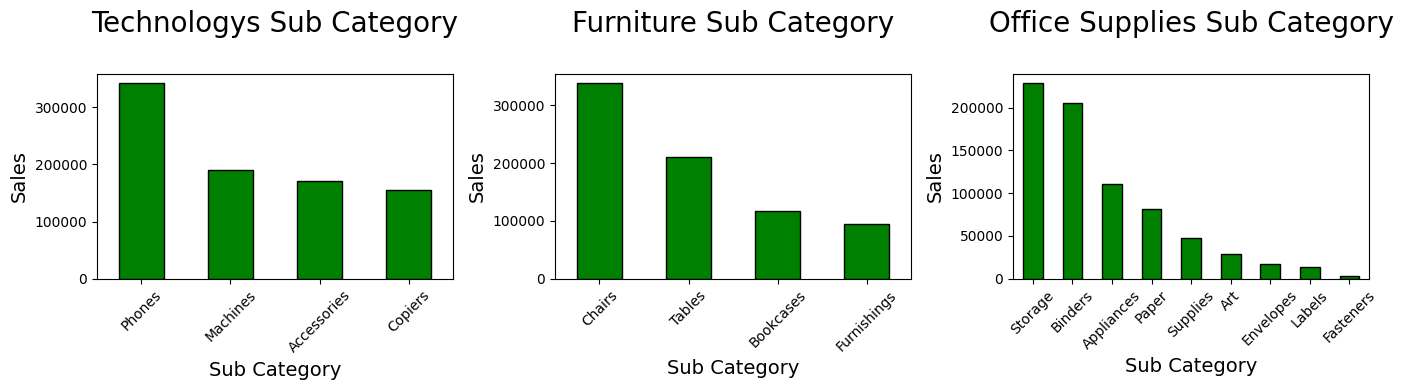

In [107]:
fig,ax = plt.subplots(1,3,figsize = (13,5))

Technology_Sub_Category.plot(
    kind='pie' ,
    ylabel='' ,
    autopct='%1.1f%%' ,
    shadow = True ,
    startangle = 0 ,
    explode = [.05 ,.05,.05,.05] ,
    wedgeprops = {'edgecolor' :'black'} ,
    ax=ax[0]
)

Furniture_Sub_Category.plot(
  kind='pie' ,
  ylabel='',
  autopct = '%1.2f%%' ,
  shadow = True ,
  startangle = 0 ,
  explode = [.05 ,.05,.05,.05] ,
  wedgeprops = {'edgecolor' :'black'} ,
  ax = ax[1]
)

Office_Supplies_Sub_Category_pie.plot(
    kind='pie' ,
    ylabel='' ,
    autopct='%1.1f%%' ,
    shadow = True ,
    startangle = 90 ,
    explode = explode_len ,
    wedgeprops = {'edgecolor' :'black'} ,
    labeldistance = 1.2,
    ax=ax[2]
)

ax[0].set_title('Technology Sub Category' , fontsize = 20  ,pad = 30)
ax[1].set_title('Furniture Sub Category' , fontsize = 20  ,pad = 30)
ax[2].set_title('Office Supplies Sub Category' , fontsize = 20 ,pad = 30)

plt.tight_layout()
plt.show()


fig,ax = plt.subplots(1,3,figsize = (14,4))

Technology_Sub_Category.plot(
    kind='bar' ,
    edgecolor  ='black' ,
    color = 'g',
    ax=ax[0]
)

Furniture_Sub_Category.plot(
    kind='bar' ,
    edgecolor  ='black' ,
    color = 'g',
    ax = ax[1]
)

Office_Supplies_Sub_Category.plot(
    kind='bar' ,
    edgecolor  ='black' ,
    color = 'g',
    ax = ax[2]
)

ax[0].tick_params(axis = 'x' , rotation = 45)
ax[0].set_ylabel('Sales' , fontsize = 14)
ax[0].set_xlabel('Sub Category' , fontsize = 14)
ax[0].set_title('Technologys Sub Category' , fontsize = 20 , pad = 30)

ax[1].tick_params(axis = 'x' , rotation = 45)
ax[1].set_ylabel('Sales' , fontsize = 14)
ax[1].set_xlabel('Sub Category' , fontsize = 14)
ax[1].set_title('Furniture Sub Category' , fontsize = 20 , pad = 30)

ax[2].tick_params(axis = 'x' , rotation = 45)
ax[2].set_ylabel('Sales' , fontsize = 14)
ax[2].set_xlabel('Sub Category' , fontsize = 14)
ax[2].set_title('Office Supplies Sub Category' , fontsize = 20 , pad = 30)

plt.tight_layout()
plt.show()


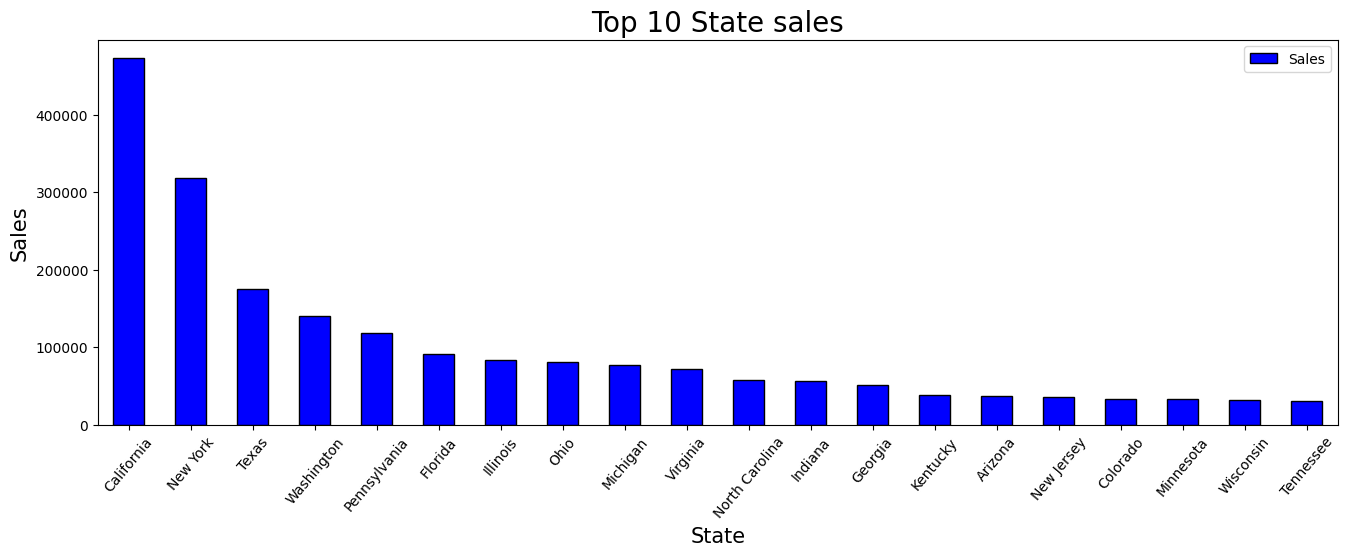

In [108]:

Top_20_State_sales.plot(
    kind='bar' ,
    figsize=(16,5) ,
    edgecolor = 'black' ,
    color = 'b'
)


plt.xticks(rotation = 50)
plt.xlabel('State' , fontsize = 15)
plt.ylabel('Sales' , fontsize =15)

plt.legend()
plt.title('Top 10 State sales' , fontsize = 20)
plt.show()

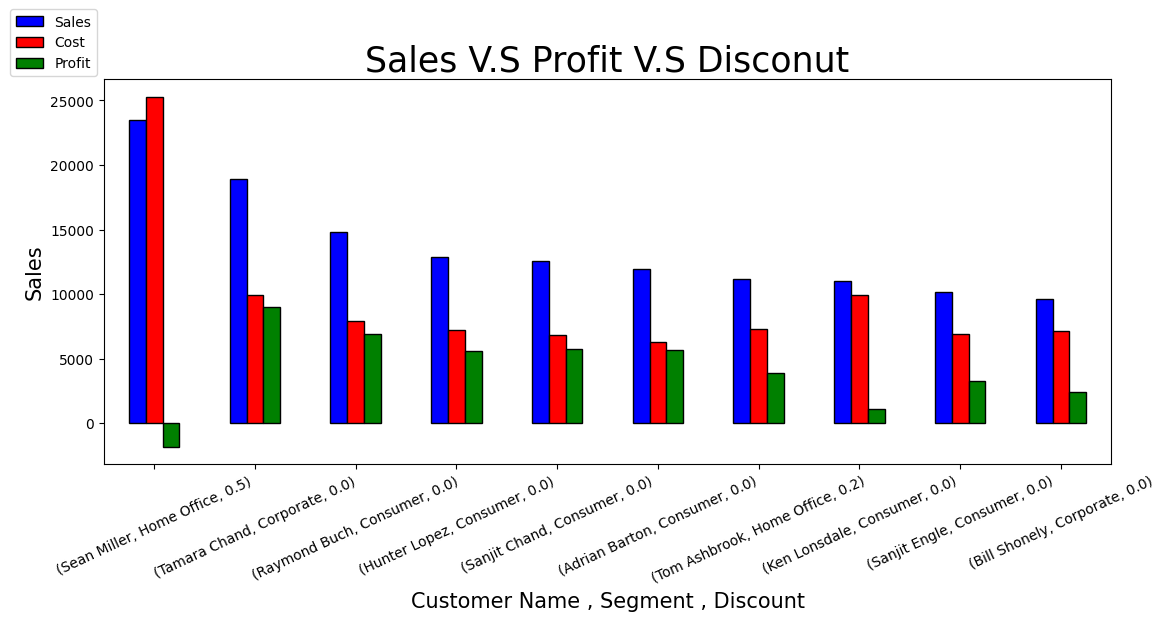

In [109]:
profit.plot(
    kind='bar' ,
    figsize=(13 ,5)  ,
    edgecolor = 'black' ,
    color = ['b' , 'r' , 'g']
)

plt.xticks(rotation = 25)
plt.ylabel('Sales' , fontsize = 15)
plt.xlabel('Customer Name , Segment , Discount' , fontsize = 15)

plt.title('Sales V.S Profit V.S Disconut' , fontsize = 25)
plt.legend( loc = 'upper left' , bbox_to_anchor = (-.1,1.2))
plt.show()

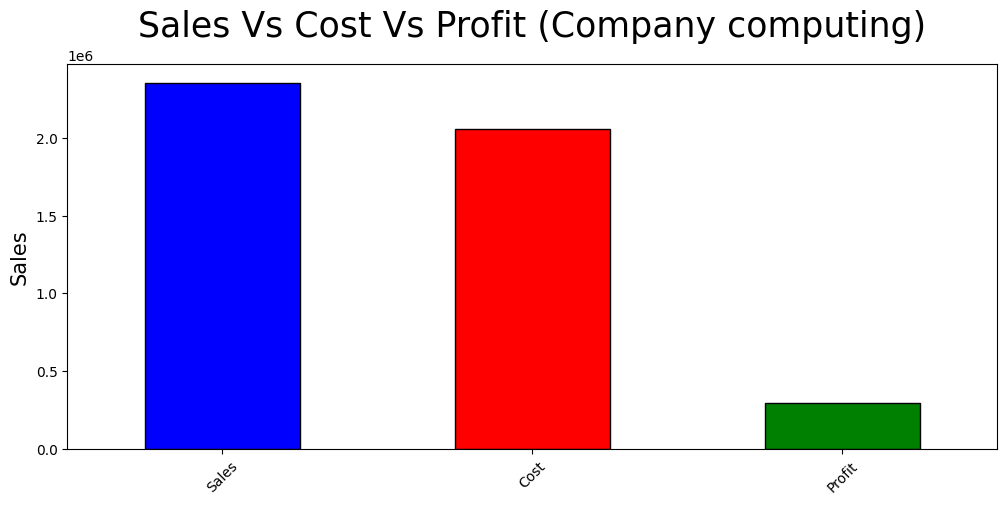

In [110]:
company_computing.plot(
    kind='bar' ,
    edgecolor = 'black' ,
    color = ['blue', 'red'  , 'green'] ,
    figsize=(12,5)
)

plt.ylabel('Sales' , fontsize = 15)
plt.title('Sales Vs Cost Vs Profit (Company computing)' , fontsize = 25 , pad=20)
plt.xticks(rotation = 45)

plt.show()

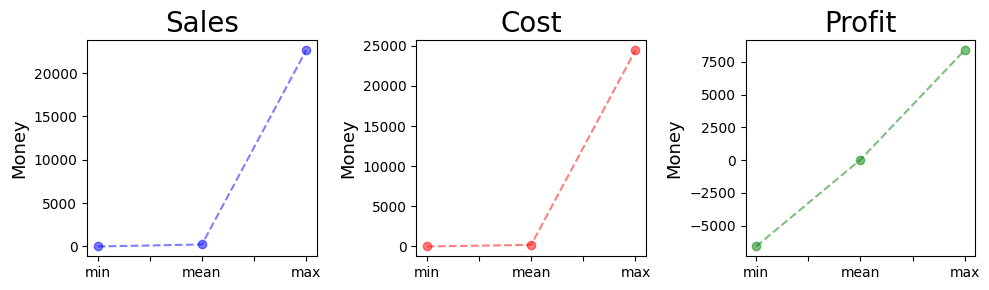

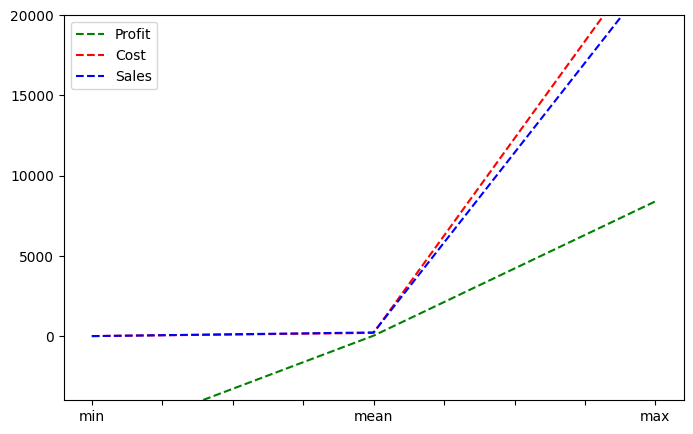

In [111]:
fig , ax = plt.subplots(1,3,figsize=(10,3))

Company_Productivity['Sales'].plot(
    ax=ax[0] ,
    color ='b' ,
    marker = 'o' ,
    alpha = .5 ,
    linestyle = '--'
)

Company_Productivity['Cost'].plot(
    ax=ax[1] ,
    color = 'r' ,
    marker = 'o' ,
    alpha = .5 ,
    linestyle = '--'
)

Company_Productivity['Profit'].plot(
    ax=ax[2] ,
    color = 'g' ,
    marker = 'o' ,
    alpha = .5 ,
    linestyle = '--'
)

ax[0].set_ylabel('Money' , fontsize = 13)
ax[0].set_title('Sales' , fontsize = 20)

ax[1].set_ylabel('Money' , fontsize = 13)
ax[1].set_title('Cost' , fontsize = 20)

ax[2].set_ylabel('Money' , fontsize = 13)
ax[2].set_title('Profit' , fontsize = 20)

plt.tight_layout()
plt.show()



zoom = Company_Productivity.plot(figsize=(8,5) , color = ['g' , 'r' , 'b']   ,alpha = 1 , linestyle = '--')
zoom.set_ylim(-4000, 20000)
plt.show()

# Model ML

In [112]:
df_model = df[['Ship Mode' , 'Discount' ,'Segment' , 'Category' , 'Sub-Category' , 'Quantity' , 'Product ID' , 'distribution' ,'Sales' ,  'Cost' , 'Profit' ]]


In [113]:
df_model['distribution'] = df_model['distribution'].astype('string')

C:\Users\ahmed\AppData\Local\Temp\ipykernel_20632\2117296952.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['distribution'] = df_model['distribution'].astype('string')


In [114]:
df_model['distribution'] = df_model['distribution'].str.extract('(\d+)').astype(int)

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\ahmed\AppData\Local\Temp\ipykernel_20632\2645691659.py:1: SyntaxWarning: invalid escape sequence '\d'
  df_model['distribution'] = df_model['distribution'].str.extract('(\d+)').astype(int)
C:\Users\ahmed\AppData\Local\Temp\ipykernel_20632\2645691659.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['distribution'] = df_model['distribution'].str.extract('(\d+)').astype(int)


In [115]:
ship_mode_order = [['First Class', 'Same Day' , 'Second Class',  'Standard Class']]

enc = OrdinalEncoder(categories=ship_mode_order)
df_model['Ship Mode'] = enc.fit_transform(df_model[['Ship Mode']]).astype(int)


C:\Users\ahmed\AppData\Local\Temp\ipykernel_20632\2097289491.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['Ship Mode'] = enc.fit_transform(df_model[['Ship Mode']]).astype(int)


In [116]:


encoder = OrdinalEncoder()
obj_cols = df_model.select_dtypes(include=['string']).columns


df_model[obj_cols] = encoder.fit_transform(df_model[obj_cols])

C:\Users\ahmed\AppData\Local\Temp\ipykernel_20632\91469005.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model[obj_cols] = encoder.fit_transform(df_model[obj_cols])


In [117]:
Q1 = df['Sales'].quantile(0.25)
Q3 = df['Sales'].quantile(0.75)
IQR = Q3 - Q1

outliers_sales_sales = df[(df['Sales'] < Q1 - 1.5*IQR) | (df['Sales'] > Q3 + 1.5*IQR)]


In [118]:
Q1 = df['Profit'].quantile(0.25)
Q3 = df['Profit'].quantile(0.75)
IQR = Q3 - Q1

outliers_sales_profit = df[(df['Profit'] < Q1 - 1.5*IQR) | (df['Profit'] > Q3 + 1.5*IQR)]


In [119]:
Q1 = df['Cost'].quantile(0.25)
Q3 = df['Cost'].quantile(0.75)
IQR = Q3 - Q1

outliers_sales_cost = df[(df['Cost'] < Q1 - 1.5*IQR) | (df['Cost'] > Q3 + 1.5*IQR)]


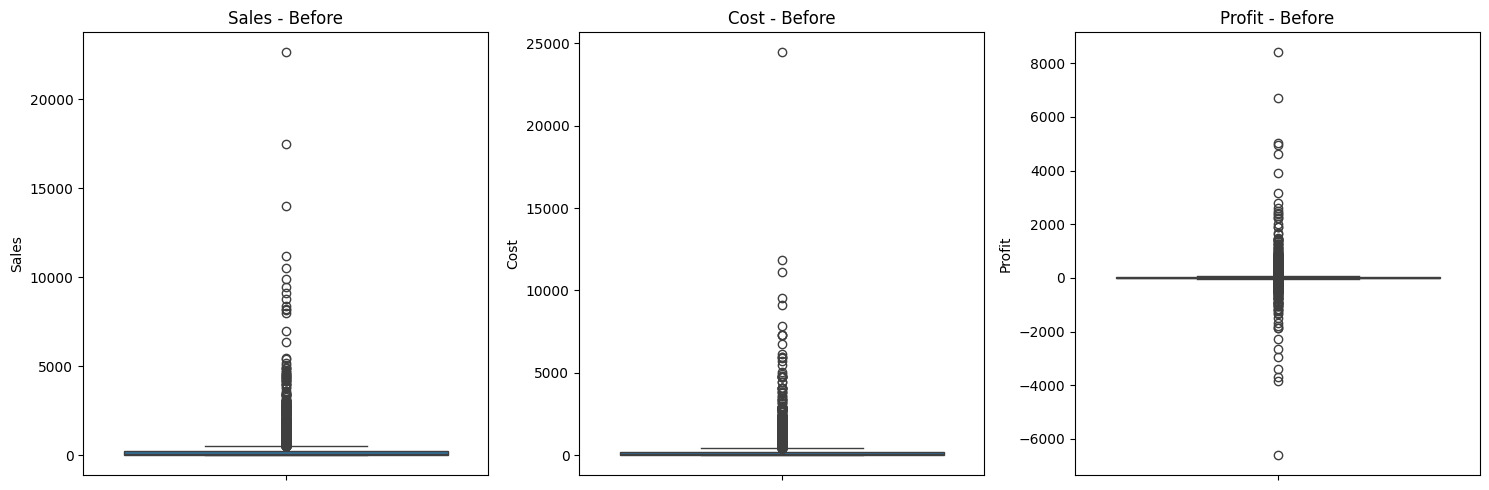

In [120]:

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.boxplot(y=df_model['Sales'])
plt.title('Sales - Before')

plt.subplot(1,3,2)
sns.boxplot(y=df_model['Cost'])
plt.title('Cost - Before')

plt.subplot(1,3,3)
sns.boxplot(y=df_model['Profit'])
plt.title('Profit - Before')

plt.tight_layout()
plt.show()

In [121]:

df_model['Sales_capped'] = winsorize(df_model['Sales'], limits=[0.01, 0.01])   # 1% lower & upper
df_model['Cost_capped'] = winsorize(df_model['Cost'], limits=[0.01, 0.01])
df_model['Profit_capped'] = winsorize(df_model['Profit'], limits=[0.01, 0.01])

C:\Users\ahmed\AppData\Local\Temp\ipykernel_20632\1003367824.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['Sales_capped'] = winsorize(df_model['Sales'], limits=[0.01, 0.01])   # 1% lower & upper
C:\Users\ahmed\AppData\Local\Temp\ipykernel_20632\1003367824.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['Cost_capped'] = winsorize(df_model['Cost'], limits=[0.01, 0.01])
C:\Users\ahmed\AppData\Local\Temp\ipykernel_20632\1003367824.py:3: SettingWithCopyWarning: 
A value is trying to 

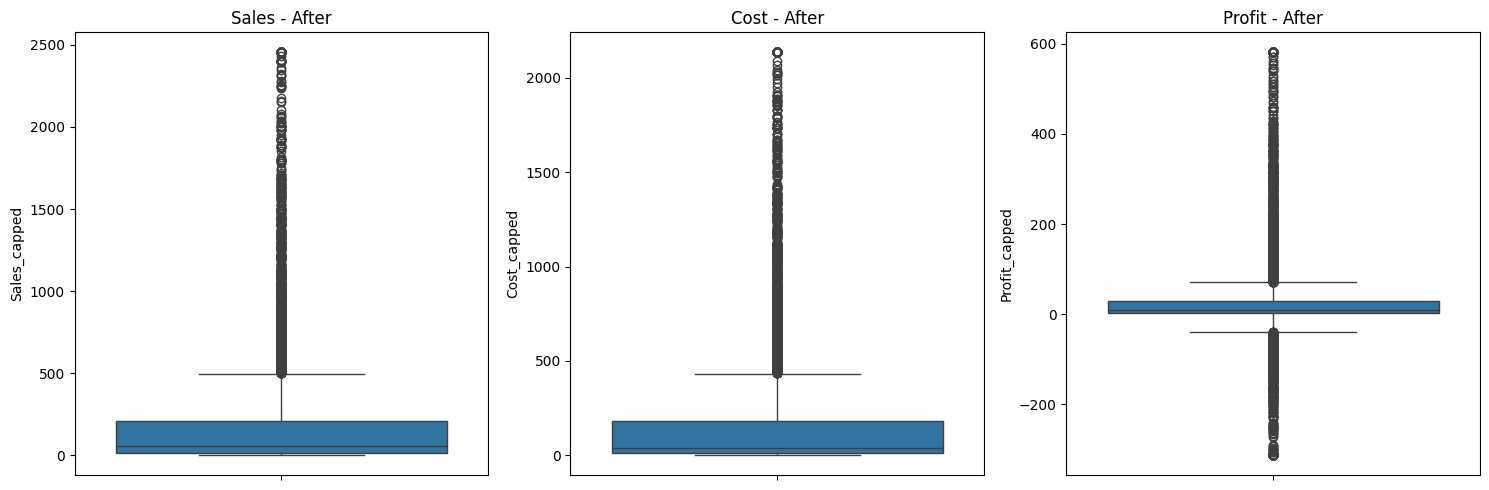

In [122]:

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.boxplot(y=df_model['Sales_capped'])
plt.title('Sales - After')

plt.subplot(1,3,2)
sns.boxplot(y=df_model['Cost_capped'])
plt.title('Cost - After')

plt.subplot(1,3,3)
sns.boxplot(y=df_model['Profit_capped'])
plt.title('Profit - After')

plt.tight_layout()
plt.show()

In [123]:
X = df_model.drop(['Sales', 'Discount' ,'Cost', 'Profit', 'distribution'], axis=1)
y = df_model[['Sales', 'Cost', 'Profit', 'distribution']]

In [124]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

base_model = LinearRegression()
multi_lr = MultiOutputRegressor(base_model)

multi_lr.fit(X_train, y_train)

y_pred = multi_lr.predict(X_test)

mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
r2 = [r2_score(y_test.iloc[:,i], y_pred[:,i]) for i in range(y.shape[1])]

# Importance Feutures

In [125]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf = RandomForestRegressor(n_estimators=200, random_state=42)
multi_rf = MultiOutputRegressor(rf)
multi_rf.fit(X_train_scaled, y_train)

y_pred = multi_rf.predict(X_test_scaled)

from sklearn.metrics import mean_squared_error, r2_score

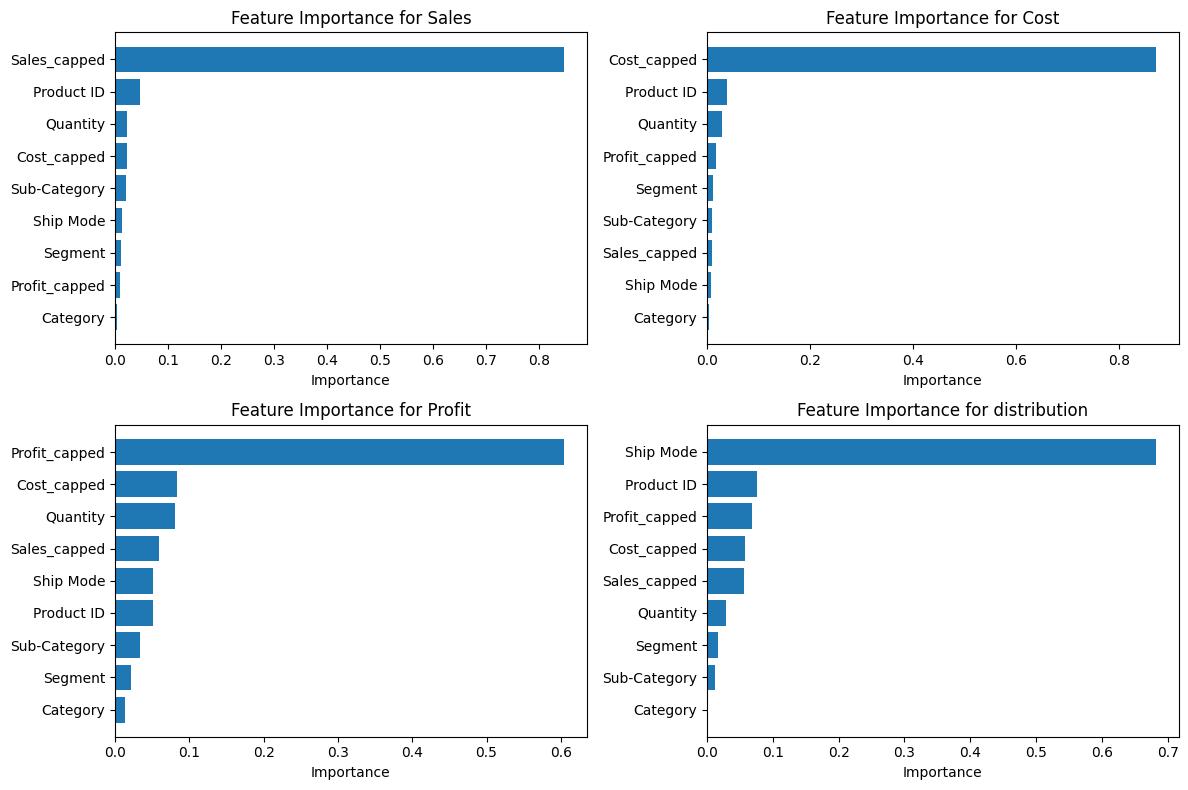

In [126]:

features = X.columns
outputs = y.columns
n_outputs = len(outputs)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()  

for i, col in enumerate(outputs):
    model = multi_rf.estimators_[i]
    importance = model.feature_importances_
    sorted_idx = np.argsort(importance)
    
    ax = axes[i]
    ax.barh(np.array(features)[sorted_idx], importance[sorted_idx])
    ax.set_title(f'Feature Importance for {col}')
    ax.set_xlabel('Importance')


for j in range(i+1, 4):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
